# Fraud Detection with Graph databases and Machine Learning

## Importing the required Python libraries

In [0]:

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# pip install imblearn
from imblearn.over_sampling import SMOTE 
from collections import Counter #for Smote

## Loading and exploring the banksim dataset 

In [27]:
banksim_df = pd.read_csv("bs140513_032310.csv")
banksim_df.head(10)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0
5,0,'C1315400589','3','F','28007','M348934600','28007','es_transportation',25.81,0
6,0,'C765155274','1','F','28007','M348934600','28007','es_transportation',9.10,0
7,0,'C202531238','4','F','28007','M348934600','28007','es_transportation',21.17,0
8,0,'C105845174','3','M','28007','M348934600','28007','es_transportation',32.40,0
9,0,'C39858251','5','F','28007','M348934600','28007','es_transportation',35.40,0


In [28]:
banksim_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


Viewing the split of the output classes - fraudulent and genuine transactions

In [29]:
banksim_df['fraud'].value_counts()

0    587443
1      7200
Name: fraud, dtype: int64

In [30]:
# Number of unique values per column in the banksim dataset
banksim_df.nunique()

step             180
customer        4112
age                8
gender             4
zipcodeOri         1
merchant          50
zipMerchant        1
category          15
amount         23767
fraud              2
dtype: int64

## Preprocessing the data 

In [31]:
# Obtaining the number of null values in each column
banksim_df.isna().sum()

step           0
customer       0
age            0
gender         0
zipcodeOri     0
merchant       0
zipMerchant    0
category       0
amount         0
fraud          0
dtype: int64

Looks like there are no null values in the dataset.

In [32]:
# Retrieving the class attribute from the dataframe
Y_before_smote = banksim_df['fraud']
Y_before_smote.head()

0    0
1    0
2    0
3    0
4    0
Name: fraud, dtype: int64

In [0]:
'''
Removing unwanted columns
Since zipcodeOri and zipMerchant have the same value for all the rows, these columns are redundant
'''

feature_df = banksim_df.drop(['step', 'customer', 'zipcodeOri', 'zipMerchant', 'fraud'], axis=1)

In [34]:
feature_df.head()

,age,gender,merchant,category,amount
0,'4','M','M348934600','es_transportation',4.55
1,'2','M','M348934600','es_transportation',39.68
2,'4','F','M1823072687','es_transportation',26.89
3,'3','M','M348934600','es_transportation',17.25
4,'5','M','M348934600','es_transportation',35.72


In [35]:
# One hot encoding the categorical variables
feature_df = pd.get_dummies(feature_df, columns=['age', 'gender', 'category', 'merchant'])
feature_df.head()

,amount,age_'0',age_'1',age_'2',age_'3',age_'4',age_'5',age_'6',age_'U',gender_'E',gender_'F',gender_'M',gender_'U',category_'es_barsandrestaurants',category_'es_contents',category_'es_fashion',category_'es_food',category_'es_health',category_'es_home',category_'es_hotelservices',category_'es_hyper',category_'es_leisure',category_'es_otherservices',category_'es_sportsandtoys',category_'es_tech',category_'es_transportation',category_'es_travel',category_'es_wellnessandbeauty',merchant_'M1053599405',merchant_'M117188757',merchant_'M1198415165',merchant_'M1294758098',merchant_'M1313686961',merchant_'M1352454843',merchant_'M1353266412',merchant_'M1400236507',merchant_'M1416436880',merchant_'M151143676',merchant_'M1535107174',merchant_'M1600850729',merchant_'M1649169323',merchant_'M1726401631',merchant_'M17379832',merchant_'M1741626453',merchant_'M1748431652',merchant_'M1788569036',merchant_'M1823072687',merchant_'M1842530320',merchant_'M1872033263',merchant_'M1873032707',merchant_'M1888755466',merchant_'M1913465890',merchant_'M1946091778',merchant_'M2011752106',merchant_'M2080407379',merchant_'M209847108',merchant_'M2122776122',merchant_'M348875670',merchant_'M348934600',merchant_'M349281107',merchant_'M3697346',merchant_'M45060432',merchant_'M480139044',merchant_'M495352832',merchant_'M50039827',merchant_'M547558035',merchant_'M677738360',merchant_'M692898500',merchant_'M732195782',merchant_'M78078399',merchant_'M840466850',merchant_'M855959430',merchant_'M857378720',merchant_'M85975013',merchant_'M923029380',merchant_'M933210764',merchant_'M97925176',merchant_'M980657600'
0,4.55,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,39.68,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,26.89,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,17.25,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,35.72,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
print('Original dataset shape %s' % Counter(Y_before_smote))

X_before_smote = feature_df
print(feature_df.shape)
sm = SMOTE(random_state=1)
# Applying smote to dataset, result is nparray
X_after_smote, Y_after_smote = sm.fit_resample(X_before_smote, Y_before_smote)
                                               
# Converting back tp data frame from nparray
X_after_smote_df = pd.DataFrame(X_after_smote, columns=X_before_smote.columns)
Y_after_smote_df = pd.DataFrame(Y_after_smote, columns = ["fraud"])
                                               
print('dataset shape after smote %s' % Counter(Y_after_smote))

Original dataset shape Counter({0: 587443, 1: 7200})
(594643, 78)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


dataset shape after smote Counter({0: 587443, 1: 587443})


In [37]:
# Standardizing the features
standard_scaler = StandardScaler()
scaled_df = pd.DataFrame(standard_scaler.fit_transform(X_after_smote_df), columns = X_after_smote_df.columns)

scaled_df.head()

,amount,age_'0',age_'1',age_'2',age_'3',age_'4',age_'5',age_'6',age_'U',gender_'E',gender_'F',gender_'M',gender_'U',category_'es_barsandrestaurants',category_'es_contents',category_'es_fashion',category_'es_food',category_'es_health',category_'es_home',category_'es_hotelservices',category_'es_hyper',category_'es_leisure',category_'es_otherservices',category_'es_sportsandtoys',category_'es_tech',category_'es_transportation',category_'es_travel',category_'es_wellnessandbeauty',merchant_'M1053599405',merchant_'M117188757',merchant_'M1198415165',merchant_'M1294758098',merchant_'M1313686961',merchant_'M1352454843',merchant_'M1353266412',merchant_'M1400236507',merchant_'M1416436880',merchant_'M151143676',merchant_'M1535107174',merchant_'M1600850729',merchant_'M1649169323',merchant_'M1726401631',merchant_'M17379832',merchant_'M1741626453',merchant_'M1748431652',merchant_'M1788569036',merchant_'M1823072687',merchant_'M1842530320',merchant_'M1872033263',merchant_'M1873032707',merchant_'M1888755466',merchant_'M1913465890',merchant_'M1946091778',merchant_'M2011752106',merchant_'M2080407379',merchant_'M209847108',merchant_'M2122776122',merchant_'M348875670',merchant_'M348934600',merchant_'M349281107',merchant_'M3697346',merchant_'M45060432',merchant_'M480139044',merchant_'M495352832',merchant_'M50039827',merchant_'M547558035',merchant_'M677738360',merchant_'M692898500',merchant_'M732195782',merchant_'M78078399',merchant_'M840466850',merchant_'M855959430',merchant_'M857378720',merchant_'M85975013',merchant_'M923029380',merchant_'M933210764',merchant_'M97925176',merchant_'M980657600'
0,-0.431067,-0.07947,-0.343603,-0.743130,-0.607238,2.21579,-0.349801,-0.213804,-0.037362,-0.037362,-1.307933,1.312797,-0.020941,-0.117944,-0.027456,-0.117465,-0.151185,-0.427614,-0.159658,-0.210581,-0.162852,-0.193772,-0.133336,-0.446737,-0.116515,1.151503,-0.208785,-0.265519,-0.076417,-0.004228,-0.178085,-0.12222,-0.021184,-0.017749,-0.073735,-0.025708,-0.013685,-0.117944,-0.127454,-0.047312,-0.110772,-0.001598,-0.127447,-0.135459,-0.056763,-0.012413,-0.585176,-0.025291,-0.021144,-0.134925,-0.133336,-0.05836,-0.06759,-0.117991,-0.060225,-0.110935,-0.127801,-0.029176,2.172387,-0.04958,-0.155985,-0.022089,-0.404374,-0.049288,-0.067709,-0.096168,-0.017459,-0.047376,-0.200234,-0.071723,-0.113142,-0.162852,-0.088314,-0.151185,-0.092927,-0.032938,-0.022585,-0.39221
1,-0.376545,-0.07947,-0.343603,1.510355,-0.607238,-0.51061,-0.349801,-0.213804,-0.037362,-0.037362,-1.307933,1.312797,-0.020941,-0.117944,-0.027456,-0.117465,-0.151185,-0.427614,-0.159658,-0.210581,-0.162852,-0.193772,-0.133336,-0.446737,-0.116515,1.151503,-0.208785,-0.265519,-0.076417,-0.004228,-0.178085,-0.12222,-0.021184,-0.017749,-0.073735,-0.025708,-0.013685,-0.117944,-0.127454,-0.047312,-0.110772,-0.001598,-0.127447,-0.135459,-0.056763,-0.012413,-0.585176,-0.025291,-0.021144,-0.134925,-0.133336,-0.05836,-0.06759,-0.117991,-0.060225,-0.110935,-0.127801,-0.029176,2.172387,-0.04958,-0.155985,-0.022089,-0.404374,-0.049288,-0.067709,-0.096168,-0.017459,-0.047376,-0.200234,-0.071723,-0.113142,-0.162852,-0.088314,-0.151185,-0.092927,-0.032938,-0.022585,-0.39221
2,-0.396395,-0.07947,-0.343603,-0.743130,-0.607238,2.21579,-0.349801,-0.213804,-0.037362,-0.037362,0.827282,-0.824331,-0.020941,-0.117944,-0.027456,-0.117465,-0.151185,-0.427614,-0.159658,-0.210581,-0.162852,-0.193772,-0.133336,-0.446737,-0.116515,1.151503,-0.208785,-0.265519,-0.076417,-0.004228,-0.178085,-0.12222,-0.021184,-0.017749,-0.073735,-0.025708,-0.013685,-0.117944,-0.127454,-0.047312,-0.110772,-0.001598,-0.127447,-0.135459,-0.056763,-0.012413,1.708888,-0.025291,-0.021144,-0.134925,-0.133336,-0.05836,-0.06759,-0.117991,-0.060225,-0.110935,-0.127801,-0.029176,-0.460323,-0.04958,-0.155985,-0.022089,-0.404374,-0.049288,-0.067709,-0.096168,-0.017459,-0.047376,-0.200234,-0.071723,-0.113142,-0.162852,-0.088314,-0.151185,-0.092927,-0.032938,-0.022585,-0.39221
3,-0.411357,-0.07947,-0.343603,-0.743130,1.846655,-0.51061,-0.349801,-0.213804,-0.037362,-

## Training supervised learning models using intrinsic features from the dataset

(1174886, 57)
(1174886, 56)


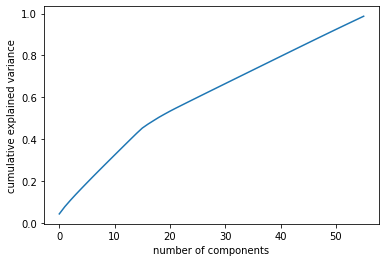

In [40]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

print(scaled_df.shape)
pca = PCA(0.98)
scaled_df = pca.fit_transform(scaled_df)
print(scaled_df.shape)
scaled_df = pd.DataFrame(scaled_df)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [0]:
k_fold = KFold(n_splits=5, random_state=None, shuffle=False)


random_forest = RandomForestClassifier(max_depth=4, n_estimators=150)
svm = SVC(gamma="auto")
logistic_regression = LogisticRegression(solver='lbfgs')
scaled_df = scaled_df.values
Y_after_smote_df = Y_after_smote_df.values

In [0]:
# Random Forest Classifier

for train_index, test_index in k_fold.split(scaled_df):
    X_train, X_test = scaled_df[train_index], scaled_df[test_index]
    y_train, y_test = Y_after_smote_df[train_index], Y_after_smote_df[test_index]
    
    clf = random_forest.fit(X_train, y_train)

    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions) * 100

    metrics = precision_recall_fscore_support(y_test, predictions, average='macro')
    precision, recall = metrics[0], metrics[1]
    f1_score = 2 * (precision * recall) / (precision + recall)

    
    print("Accuracy = {0:.4f}%".format(accuracy))
    print("Precision = {0:.4f}".format(precision))
    print("Recall = {0:.4f}".format(recall))
    print("F1 Score = {0:.4f}".format(f1_score))
    print("---------------------------------------------")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Accuracy = 93.3781%
Precision = 0.5848
Recall = 0.9660
F1 Score = 0.7286
---------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [0]:
# SVM Classifier

# for train_index, test_index in k_fold.split(scaled_df):
#     X_train, X_test = scaled_df[train_index], scaled_df[test_index]
#     y_train, y_test = Y_after_smote_df[train_index], Y_after_smote_df[test_index]
    
#     clf = svm.fit(X_train, y_train)
#     predictions = clf.predict(X_test)
#     accuracy = accuracy_score(y_test, predictions) * 100

#     metrics = precision_recall_fscore_support(y_test, predictions, average='macro')
#     precision, recall = metrics[0], metrics[1]
#     f1_score = 2 * (precision * recall) / (precision + recall)

    
#     print("Accuracy = {0:.4f}%".format(accuracy))
#     print("Precision = {0:.4f}".format(precision))
#     print("Recall = {0:.4f}".format(recall))
#     print("F1 Score = {0:.4f}".format(f1_score))
#     print("---------------------------------------------")

In [0]:
# Logistic Regression Classifier
for train_index, test_index in k_fold.split(scaled_df):
    X_train, X_test = scaled_df[train_index], scaled_df[test_index]
    y_train, y_test = Y_after_smote_df[train_index], Y_after_smote_df[test_index]
    
    clf = logistic_regression.fit(X_train, y_train)

    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions) * 100

    metrics = precision_recall_fscore_support(y_test, predictions, average='macro')
    precision, recall = metrics[0], metrics[1]
    f1_score = 2 * (precision * recall) / (precision + recall)

    
    print("Accuracy = {0:.4f}%".format(accuracy))
    print("Precision = {0:.4f}".format(precision))
    print("Recall = {0:.4f}".format(recall))
    print("F1 Score = {0:.4f}".format(f1_score))
    print("---------------------------------------------")